## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

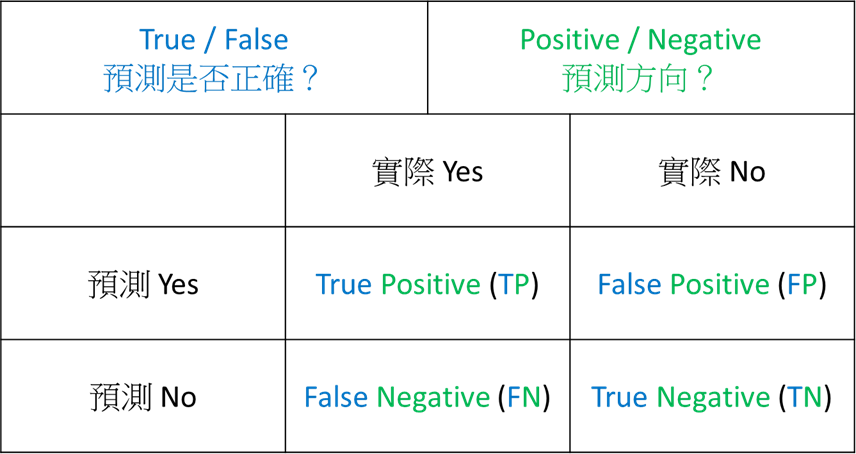

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline


# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-23 08:36:13.398639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 08:36:13.398710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def __init__(self, val_data=(x_test, y_test)):
        self.validation_data = val_data
     
    def on_train_begin(self, epoch, logs={}):
        self.params['metrics'] = []
        logs = logs or {}
        record_items = ["val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)

     
    def on_epoch_end(self, epoch, logs={}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1]>=thres)*1
        
        val_tp = sum(y_true*y_pred)
        val_tn = sum((y_true==0) & (y_pred==0))
        
        logs["val_tp"] = val_tp
        logs["val_tn"] = val_tn
        
rec_tptn = Record_tp_tn()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

2021-11-23 08:36:41.131914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 08:36:41.131976: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 08:36:41.132011: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (11402.pyspark3): /proc/driver/nvidia/version does not exist
2021-11-23 08:36:41.132322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/wanzi/ml/cupoyMarathon/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512   

2021-11-23 08:36:41.681724: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-11-23 08:36:41.890429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
49/49 [==============================] - 4s 62ms/step - loss: 2.2208 - accuracy: 0.2700 - val_loss: 2.1588 - val_accuracy: 0.1939
Epoch 2/25
49/49 [==============================] - 3s 57ms/step - loss: 1.7612 - accuracy: 0.3889 - val_loss: 1.9963 - val_accuracy: 0.2740
Epoch 3/25
49/49 [==============================] - 3s 61ms/step - loss: 1.6325 - accuracy: 0.4301 - val_loss: 1.8291 - val_accuracy: 0.3666
Epoch 4/25
49/49 [==============================] - 3s 54ms/step - loss: 1.5571 - accuracy: 0.4543 - val_loss: 1.7191 - val_accuracy: 0.4094
Epoch 5/25
49/49 [==============================] - 3s 69ms/step - loss: 1.5009 - accuracy: 0.4754 - val_loss: 1.6390 - val_accuracy: 0.4280
Epoch 6/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4536 - accuracy: 0.4899 - val_loss: 1.6080 - val_accuracy: 0.4355
Epoch 7/25
49/49 [==============================] - 3s 53ms/step - loss: 1.4152 - accuracy: 0.5038 - val_loss: 1.5618 - val_accuracy: 0.4494
Epoch 8/25
49

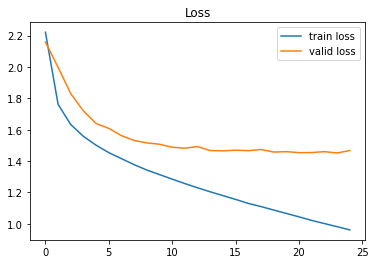

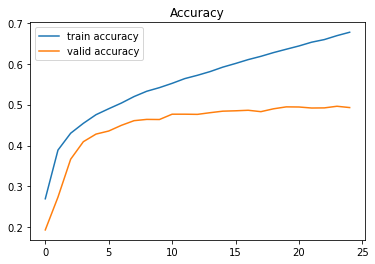

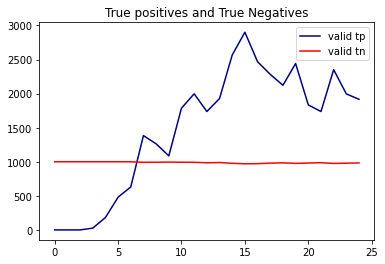

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
